# Notebook to process and visualize data about faculty research experience.

Requirements:
    
    !pip install pandas
    !pip install openai
    !pip install wordcloud

Also requires [OpenAI account](https://openai.com/) and [OpenAI API key](https://platform.openai.com/account/api-keys). The key must be placed in a text file and pointed 
to in the setup cell (open_ai_inpath) below. Alternatively, store API key in os environment variable and use the commented out snippet in setup below.

License: [CC BY-NC 3.0](https://creativecommons.org/licenses/by-nc/3.0/)


### Setup

In [1]:
import pandas as pd
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ast

from langchain.chat_models import ChatOpenAI

from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

# set paths
bio_inpath = 'data/all_bios.json'
json_outpath = 'data/all_bios_w_research_expertise.json'

# NOTE: TO USE langchain, you must set your OpenAI API key in the environment variable OPENAI_API_KEY

### Load faculty bios

To update scraped data, run scrape_bios.ipynb first.

In [ ]:
# Load data
df = pd.read_json(bio_inpath)
df

In [ ]:
# Standardize listed research areas
def standardize_research_areas(research_areas):

    if not research_areas:
        return None

    # convert comas to semicolons
    research_areas = research_areas.replace(',', ';')
    
    # split research areas on ; and remove trailing spaces
    research_areas = [x.strip() for x in research_areas.split(';')]

    # capitalize research_areas using titles
    research_areas = [x.title() for x in research_areas]
    
    # convert / to and
    research_areas = [x.replace('/', ' and ') for x in research_areas]
    
    # convert & to and
    research_areas = [x.replace('&', ' and ') for x in research_areas]

    # join into string
    research_areas = '; '.join(research_areas)

    # fix capitalization
    research_areas = research_areas.replace('And', 'and')
    research_areas = research_areas.replace('Of', 'of')
    research_areas = research_areas.replace('In', 'in')
    research_areas = research_areas.replace('For', 'for')
    research_areas = research_areas.replace(' The ', ' the ')
    research_areas = research_areas.replace(' To ', ' to ')

    # remove multiple spaces
    research_areas = ' '.join(research_areas.split())    

    return research_areas

df['listed_research_areas'] = df['listed_research_areas'].apply(standardize_research_areas)

# Convert listed research areas to a list
df['listed_research_areas'] = df['listed_research_areas'].apply(lambda x: x.split(';') if x else None)

df


### Use ChatGPT to get consolidated research areas from bios

In [ ]:
list_manual_research_areas = [
    "Aboriginal Law",
    "Academic Freedom",
    "Access to Justice",
    "Administrative Law",
    "Animal Law",
    "Anti-Discrimination",
    "Decolonization",
    "Antitrust Law",
    "Anti-Terrorism",
    "Artificial Intelligence",
    "Bail",
    "Banking Law",
    "Bankruptcy and Insolvency",
    "Bioethics",
    "Border Control",
    "Business Associations",
    "Charter of Rights and Freedoms",
    "Children's Rights",
    "Civil Litigation",
    "Civil Procedure",
    "Class Actions",
    "Climate Change",
    "Clinical Legal Education",
    "Commercial Law",
    "Communications Law",
    "Comparative Law",
    "Competition Law",
    "Computational Law",
    "Constitutional Law",
    "Construction Law",
    "Consumer Protection",
    "Contracts",
    "Corporate Governance",
    "Corporate Law",
    "Corporate Social Responsibility",
    "Criminal Law",
    "Criminal Procedure",
    "Critical Race Theory",
    "Disability Law",
    "Disinformation",
    "Dispute Resolution",
    "E-commerce Law",
    "Elder Law",
    "Election Law",
    "Employment Law",
    "Empirical Legal Studies",
    "Energy Law",
    "Entertainment Law",
    "Environmental Law",
    "Estates and Trusts",
    "Equality",
    "Evidence",
    "Family Law",
    "Federalism",
    "Feminist Legal Theory",
    "Financial Regulation",
    "Food Law",
    "Freedom of Expression",
    "Freedom of Information",
    "Gender and the Law",
    "Health Law",
    "Housing",
    "Human Rights Law",
    "Immigration and Refugee Law",
    "Indigenous Law",
    "Insurance Law",
    "Intellectual Property",
    "International Arbitration",
    "International Business Law",
    "International Criminal Law",
    "International Environmental Law",
    "International Human Rights Law",
    "International Law",
    "International Organizations",
    "International Trade Law",
    "Islamic Law",
    "Judicial Decision Making",
    "Judicial Review",
    "Jurisprudence",
    "Labour Law",
    "Land Use and Zoning Law",
    "Language Rights",
    "Law and Art",
    "Law and Development",
    "Law and Film",
    "Law and Globalization",
    "Law and Economics",
    "Law and Literature",
    "Law and Religion",
    "Law and Society",
    "Law and Technology",
    "Legal Anthropology",
    "Legal Education",
    "Legal Ethics",
    "Legal History",
    "Legal Information Technology",
    "Legal Philosophy",
    "Legal Pluralism",
    "Legal Reasoning",
    "Legal Theory",
    "Legal Writing",
    "LGBTQ+ Rights",
    "Maritime Law",
    "Media Law",
    "Mergers and Acquisitions",
    "Migrant Workers",
    "Migration",
    "Military Law",
    "Movement Lawyering",
    "Municipal Law",
    "Natural Resources Law",
    "National Security Law",
    "Negotiation",
    "Pensions",
    "Policing",
    "Political Philosophy",
    "Poverty Law",
    "Privacy Law",
    "Private International Law",
    "Professional Responsibility",
    "Property",
    "Public International Law",
    "Public Law",
    "Race and the Law",
    "Real Estate",
    "Regulatory Law",
    "Reproductive Rights",
    "Rule of Law",
    "Securities",
    "Sentencing",
    "Sexuality and the Law",
    "Social Justice",
    "Social Movements",
    "Space Law",
    "Sports Law",
    "Statutory Interpretation",
    "Tax Law",
    "Talmudic Law",
    "Third World Approaches to International Law",
    "Torts",
    "Transnational Law",
    "Trial Advocacy"
]

# create a new dictionary with the research areas as a key and the list index as the value
research_areas_dict = {research_area: i for i, research_area in enumerate(list_manual_research_areas)}


In [ ]:
def get_extracted_research_areas(row):
    if not row['bio']:
        return None
    else: 
        #print ('Getting :', row['name'])  # Uncomment to see progress
        response = chat(chat_prompt.format_prompt(bio = row['bio'][:10000], research_areas_dict = research_areas_dict).to_messages()).content
        try:
            response = ast.literal_eval(response)     
            mapped_response = [inverted_research_areas_dict[i] for i in response]
            time.sleep(0.25)
            return mapped_response
        except SyntaxError:
            return None

# invert key value pairs
inverted_research_areas_dict = {v: k for k, v in research_areas_dict.items()}

# Set up the chat prompt using langchain and openai
chat = ChatOpenAI(temperature=0, model = "gpt-4", max_tokens = 200, request_timeout = 30, max_retries=10)

system_message = "You are an automated list consolidation system. "\
    "You follow instructions precisely and literally, step by step. You only return a list of integers." 
system_message_prompt = SystemMessagePromptTemplate.from_template(system_message)

human_message = "*Faculty bio*: {bio} \n"\
        "*Consolidated dictionary*: {research_areas_dict} \n"\
        "*Task*: Return a valid python list with the value associated with each key that is implicitly or explicitly included "\
        "as an area of research expertise in the faculty bio. \n"\
        "*Return list*: "
human_message_prompt = HumanMessagePromptTemplate.from_template(human_message)

chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])


In [ ]:
##############################################################################
########### CAREFUL: INCURS COSTS TO OPENAI API #################################
##############################################################################

# Apply function to get extracted research areas via GPT
df['extracted_research_areas'] = df.apply(get_extracted_research_areas, axis=1)
df

In [ ]:
# Save to json for future use
df.to_json(json_outpath, orient='records')

In [ ]:
# View most common research areas

results = []
for index, row in df.iterrows():
    extracted_research_areas = row['extracted_research_areas']
    if extracted_research_areas == None:
        continue
    for item in extracted_research_areas:
            results.append(item)
results = set(results)
results = sorted(results)

results_dict = {}
for result in results:
    results_dict[result] = df['extracted_research_areas'].apply(lambda x: result in x if x else False).sum()

results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['count'])
results_df = results_df.rename_axis('research_area').reset_index()
results_df = results_df.sort_values(by=['count'], ascending=False)
results_df.head(40)

In [ ]:
# print a list of names from df where area is in the list of extracted_research_areas

area = "Judicial Decision Making"
for index, row in df.iterrows():
    if row['extracted_research_areas'] == None:
        continue
    if area in row['extracted_research_areas']:
        print(row['name'])

In [ ]:
# print extracted_research_areas where name = XXX

name = 'Sean Rehaag'
for index, row in df.iterrows():
    if row['name'] == name:
        print(row['extracted_research_areas'])
        print(row['bio'])



### Visualize faculty member research expertise keywords

In [2]:
# Load data (if needed)

df = pd.read_json(json_outpath)
df

,faculty,name,title,email,href,bio,listed_research_areas,extracted_research_areas
0,osgoode,Rabiat Akande,Assistant Professor,rakande@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Rabiat Akande works in the fields of...,"[Legal History, Law and Religion, Constituti...","[Comparative Law, Constitutional Law, Internat..."
1,osgoode,Saptarishi Bandopadhyay,Associate Professor,sbandopadhyay@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,I am an Associate Professor at Osgoode Hall La...,"[Law, History, and Politics of Disasters, i...","[Environmental Law, International Law, Legal H..."
2,osgoode,Stephanie Ben-Ishai,Professor and York University Distinguished Re...,sbenishai@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Stephanie Ben-Ishai is a Distinguish...,[Corporate and Commercial Law],"[Banking Law, Bankruptcy and Insolvency, Comme..."
3,osgoode,Benjamin L. Berger,Professor & York Research Chair in Pluralism a...,bberger@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Benjamin L. Berger is Professor and ...,"[Law and Religion, Criminal and Constitutiona...","[Constitutional Law, Criminal Law, Evidence, L..."
4,osgoode,Kate Glover Berger,Associate Professor,kgberger@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Kate Glover Berger joined the facult...,None,"[Administrative Law, Constitutional Law, Publi..."
...,...,...,...,...,...,...,...,...
379,uottawa-civil,David Robitaille,Professeur titulaire,david.robitaille@uottawa.ca,https://uniweb.uottawa.ca/members/1670/profile,David Robitaille est professeur titulaire à la...,None,"[Administrative Law, Constitutional Law, Envir..."
380,uottawa-civil,Terry Skolnik,Professeur agrégé,tskolnik@uottawa.ca,https://uniweb.uottawa.ca/members/4305/profile,Terry Skolnik is an associate professor (tenur...,None,"[Criminal Law, Criminal Procedure, Policing, P..."
381,uottawa-civil,Marie-Eve Sylvestre,"Doyenne, professeure titulaire",Marie-Eve.Sylvestre@uottawa.ca,https://www.uottawa.ca/faculte-droit/droit-civ...,Marie-Eve Sylvestre est doyenne et professeure...,None,"[Criminal Law, Poverty Law, Housing, Sexuality..."
382,uottawa-civil,Sophie Thériault,Vice doyenne aux études et professeure titulaire,Sophie.Theriault@uOttawa.ca,https://www.uottawa.ca/faculte-droit/droit-civ...,Sophie Thériault est professeure titulaire et ...,None,"[Indigenous Law, Natural Resources Law, Enviro..."


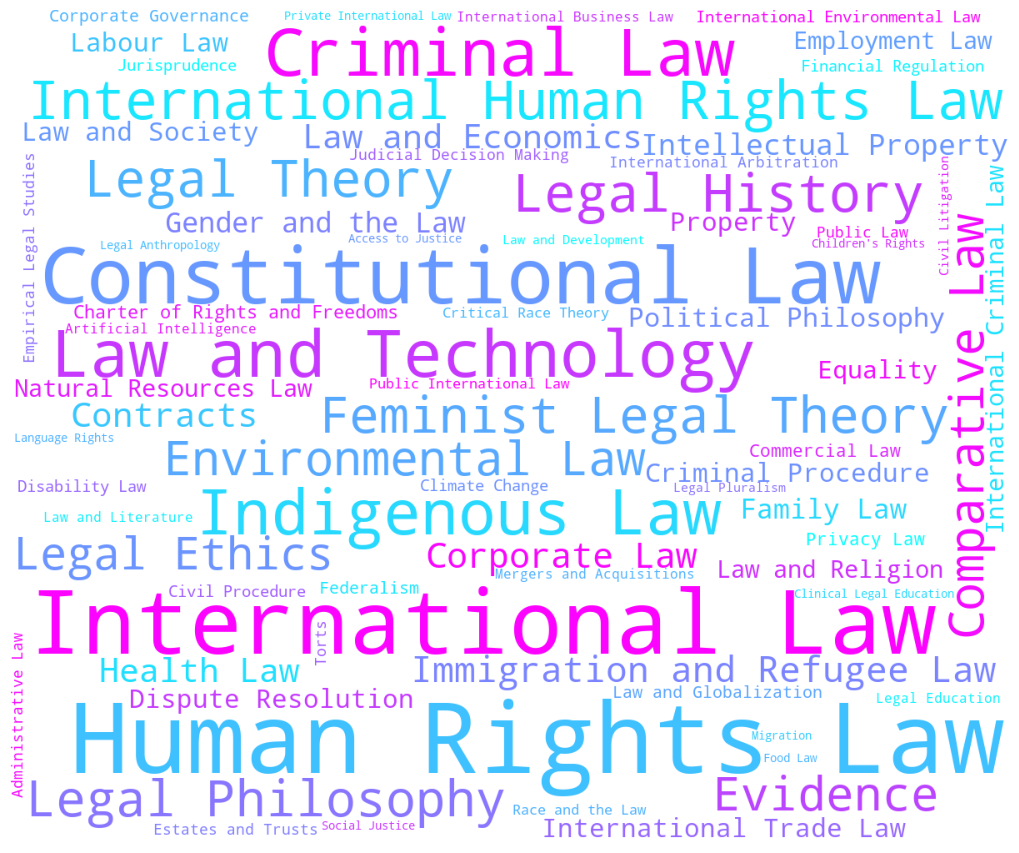

In [3]:
def create_wordcloud(df_temp, cmap_color='cool', cmap_number = 800, layout_padding = 5):
    
    df_temp['extracted_research_areas'] = df_temp['extracted_research_areas'].apply(lambda x: [] if x is None else x)

    # Join the research areas with a special character (e.g., '|')
    df_temp['joined_research_areas'] = df_temp['extracted_research_areas'].apply(lambda x: '|'.join(x))

    # Concatenate all the joined research areas
    text = ' '.join(df_temp['joined_research_areas'].values)

    # Create a WordCloud object with a white background
    colour_map = plt.cm.get_cmap(cmap_color, cmap_number)
    wordcloud = WordCloud(
        width = 1200, height = 1000,
        min_font_size = 14,
        colormap=colour_map,
        collocations=False,
        regexp=r'[^\|]+',
        background_color='white').generate(text)

    # Display the word cloud
    plt.figure(figsize = (100,10), facecolor = 'white')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = layout_padding)
    plt.show()

create_wordcloud(df, cmap_color='cool', cmap_number = 750, layout_padding = 6)

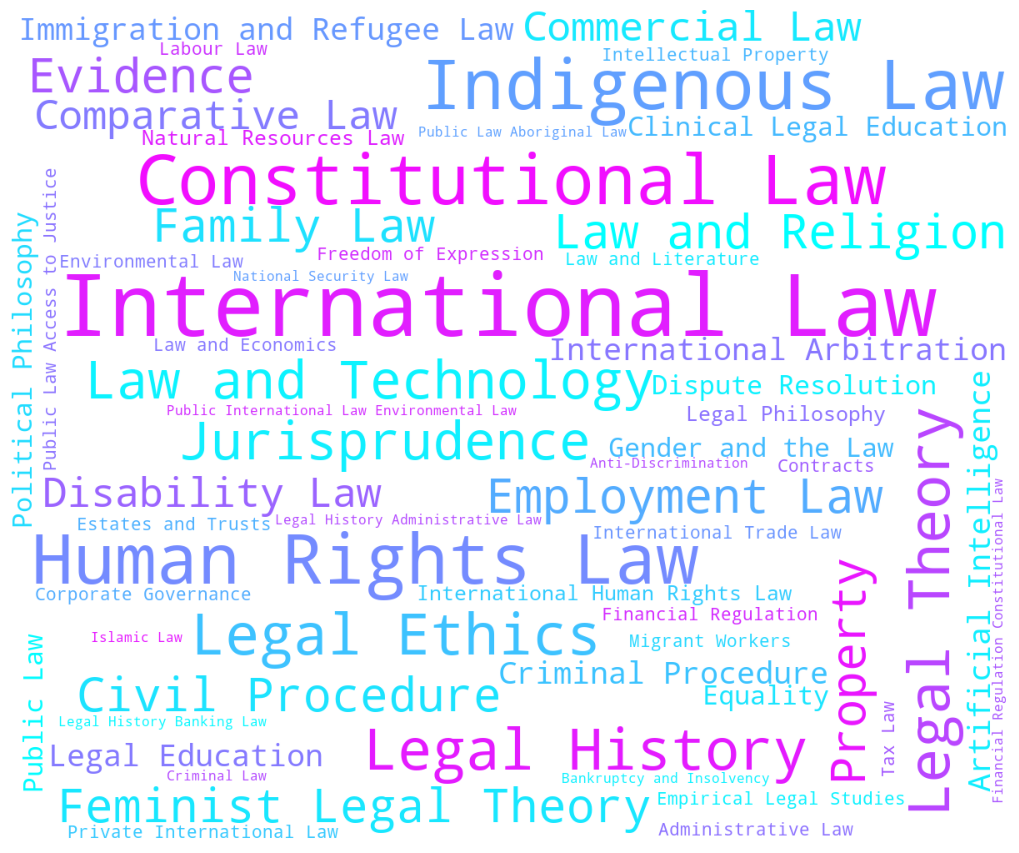

In [4]:
# get Osgoode wordcloud
df_temp = df.copy()
df_temp = df_temp[df_temp['faculty'] == 'osgoode']
df_temp = df_temp.reset_index(drop=True)
create_wordcloud(df_temp, cmap_color='cool', cmap_number = 750, layout_padding = 6)

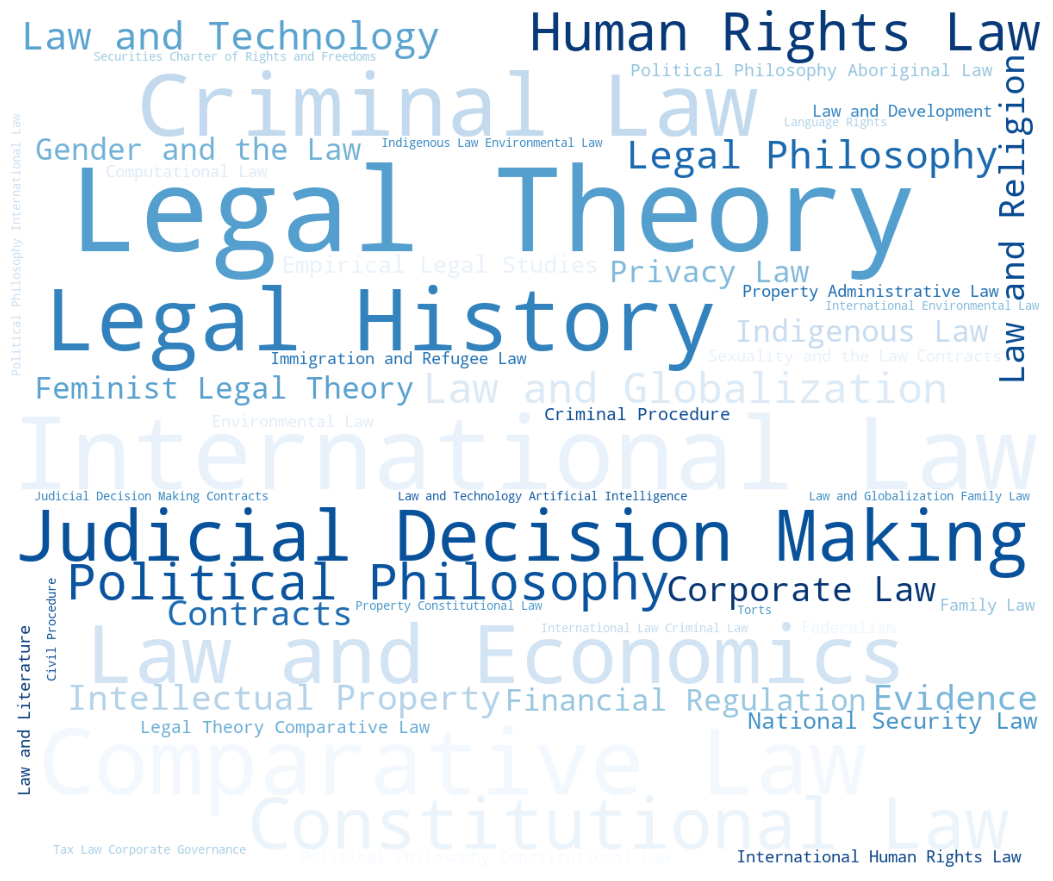

In [5]:
# get UofT wordcloud
df_temp = df.copy()
df_temp = df_temp[df_temp['faculty'] == 'u_toronto']
df_temp = df_temp.reset_index(drop=True)
create_wordcloud(df_temp, cmap_color='Blues_r', cmap_number = 625, layout_padding = 5)

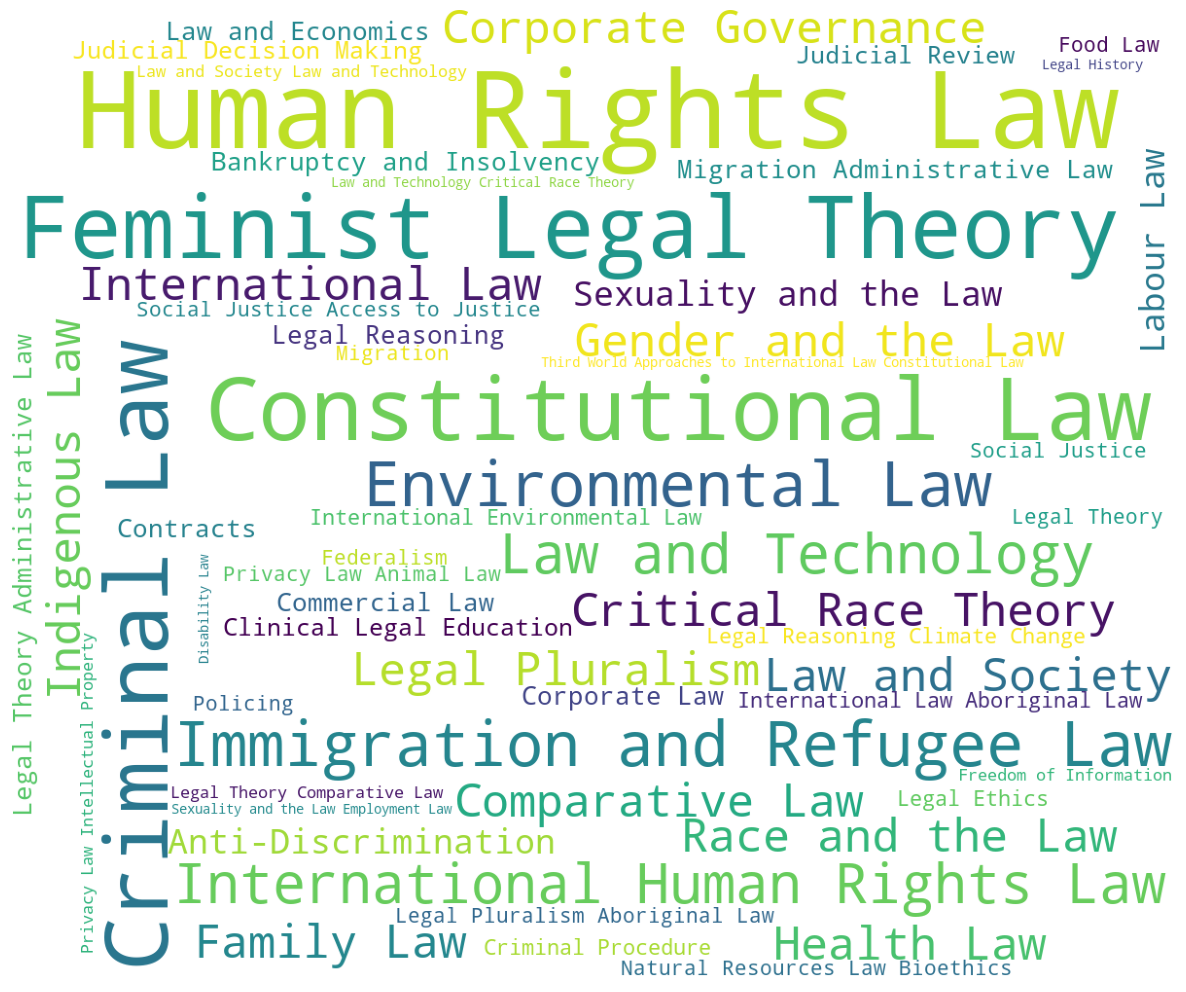

In [6]:
# get TMU wordcloud
df_temp = df.copy()
df_temp = df_temp[df_temp['faculty'] == 'tmu']
df_temp = df_temp.reset_index(drop=True)
create_wordcloud(df_temp, cmap_color='viridis', cmap_number = 100, layout_padding = 1)

### Try breaking out by gender (pronouns)

In [7]:
# function to extract pronouns from text

def get_pronouns(text):

    if not text:
        return "other"

    # Create a dictionary to keep track of the count of each pronoun
    pronoun_count = {"he": 0, "him": 0, "his": 0, "she": 0, "her": 0, "hers": 0, "they": 0, "them": 0, "their": 0, "theirs": 0}

    # prepare the text for analysis
    text = text.lower().split()

    # count the pronouns
    for word in text:
        if word in pronoun_count:
            pronoun_count[word] += 1

    # if no pronouns, return "other"
    if sum(pronoun_count.values()) == 0:
        return "other"

    # Get the most common pronouns
    most_common_pronoun = max(pronoun_count, key=pronoun_count.get)
    if most_common_pronoun in ["he", "him", "his"]:
        return "he/him"
    elif most_common_pronoun in ["she", "her", "hers"]:
        return "she/her"
    else:
        return "they/them"

# get pronouns for each bio using apply
df['pronouns'] = df['bio'].apply(get_pronouns)

# print counts of pronouns
print(df['pronouns'].value_counts())
print()
print()

# print ('------------------------')

# # Check they/them pronouns
# for index, row in df.iterrows():
#     if row['pronouns'] == 'they/them':
#         print(row['name'])
#         print(row['faculty'])
#         print(row['bio'])
#         print('')

# # NOTE: As of March 2023, no they/them pronouns in the data
# # replace they/them pronouns with other 

df['pronouns'] = df['pronouns'].replace('they/them', 'other')

# print ('------------------------')

# # Check other pronouns
# for index, row in df.iterrows():
#     if row['pronouns'] == 'other':
#         print(row['name'])
#         print(row['faculty'])
#         print(row['bio'])
#         print('')

# NOTE: Currently mostly correctly identifies bios without any pronouns (because no content or because first person)

# fix  pronouns 
df.loc[df['name'] == 'Ravi Malhotra', 'pronouns'] = 'he/him'  # error caused by French, but pronouns used in en bio
df.loc[df['name'] == 'Michael Geist', 'pronouns'] = 'he/him' # error caused by French, but pronouns used in en bio
df.loc[df['name'] == 'Ellen Zweibel', 'pronouns'] = 'other' # first person

# NOT FIXED BECAUSE NO PRONOUNS AVAILABLE
# Saptarishi Bandopadhyay No pronouns used in bio
# Peter Cziraki No bio
# Patricia Peppin First person
# Ruth Kuras No bio
# Margaret Liddle No bio
# Lisa Trabucco No bio
# Jula Hughes No pronouns used in bio
# Amir Attaran No pronouns used in bio
# Jeremy De Beer first person
# Sylvia Rich first person
# Penelope Simons first person
# LIST DOES NOT INCLUDE OTTAWA CIVIL LAW
# HAVE ONLY FIXED PRONOUNS WHERE ALSO SALARY AVAILABLE (see salaries.ipynb)

he/him       174
she/her      158
other         49
they/them      3
Name: pronouns, dtype: int64




In [8]:
# make a table of percent she/her pronouns by faculty
df_temp = df.copy()
df_temp = df_temp[df_temp['pronouns'].isin(['she/her', 'he/him'])]
df_temp['she/her'] = df_temp['pronouns'].apply(lambda x: 1 if x == 'she/her' else 0)
df_temp = df_temp.groupby('faculty').agg({'she/her': 'mean'})
df_temp

,she/her
faculty,
lakehead,0.583333
osgoode,0.596774
queens,0.394737
tmu,0.476190
u_toronto,0.377049
uottawa-civil,0.400000
uottawa-common,0.521739
western,0.289474
windsor,0.607143


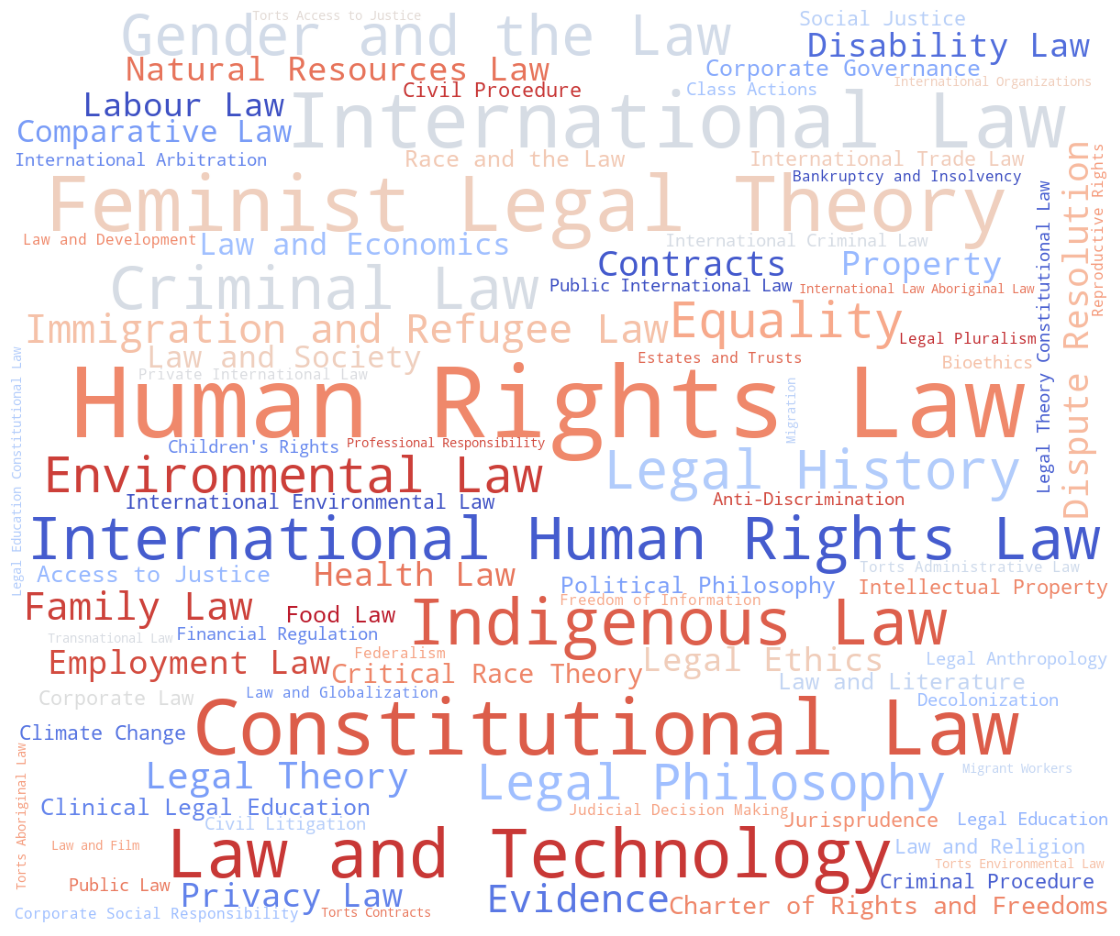

In [9]:
# get she/her wordcloud 
df_temp = df.copy()
df_temp = df[df['pronouns'] == 'she/her']
df_temp = df_temp.reset_index(drop=True)
create_wordcloud(df_temp, cmap_color='coolwarm', cmap_number = 600, layout_padding = 3)

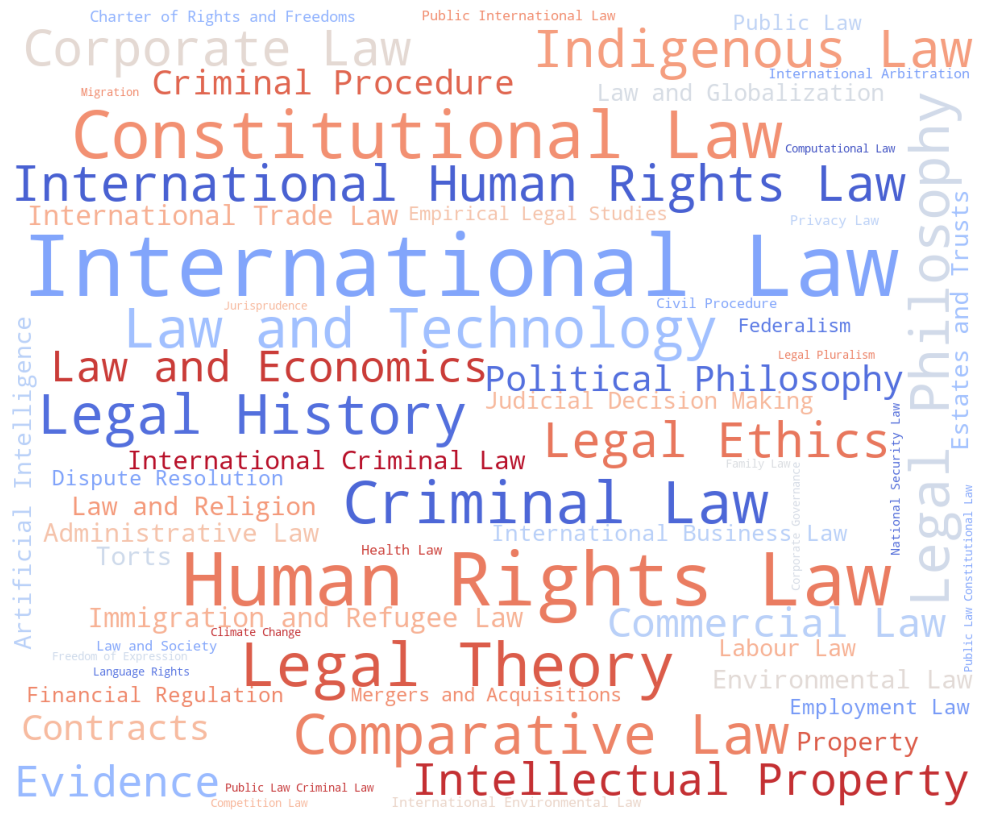

In [10]:
# get he/him wordcloud
df_temp = df.copy()
df_temp = df[df['pronouns'] == 'he/him']
df_temp = df_temp.reset_index(drop=True)
create_wordcloud(df_temp, cmap_color='coolwarm', cmap_number = 600, layout_padding = 7)